# GEONE - GEOSCLASSIC - Examples in 3D - non-stationary covariance model

## Estimation (kriging) and simulation (Sequential Gaussian Simulation, SGS)

See notebook `ex_geosclassic_1d_1.ipynb` for detail explanations about estimation (kriging) and simulation (Sequential Gaussian Simulation, SGS) in a grid.

## Non-stationary covariance model over a grid
See notebook `ex_geosclassic_1d_2_non_stat_cov.ipynb` for detail explanations on how to set non-stationarities in a grid.

## Examples in 3D
In this notebook, examples in 3D with a non-stationary covariance model are given.

## Import what is required

In [1]:
import numpy as np
# import matplotlib.pyplot as plt
import pyvista as pv
# import scipy
import time

# import package 'geone'
import geone as gn

In [2]:
# Show version of python and version of geone
import sys 
print(sys.version_info)
print('geone version: ' + gn.__version__)

sys.version_info(major=3, minor=13, micro=7, releaselevel='final', serial=0)
geone version: 1.3.0


In [3]:
pv.set_jupyter_backend('static') # static plots
# pv.set_jupyter_backend('trame')  # 3D-interactive plots

## Grid (3D)

In [4]:
nx, ny, nz = 85, 56, 34  # number of cells
sx, sy, sz = 1.0, 1.0, 1.0  # cell unit
ox, oy, oz = 0.0, 0.0, 0.0  # origin

dimension = (nx, ny, nz)
spacing = (sx, sy, sz)
origin = (ox, oy, oz)

## Covariance model

In 3D, a covariance model is given by an instance of the class `geone.covModel.covModel3D` (or `geone.covModel.covModel1D` for omni-directional (isotropic) case).

### Base covariance model (sationary)
The angles are set to `0`, local rotation will be set further.

In [5]:
# Define the base covariance model (stationary)
cov_model = gn.covModel.CovModel3D(elem=[
    ('gaussian', {'w':8.5, 'r':[10, 40, 10]}), # elementary contribution
    ('nugget', {'w':0.5})                      # elementary contribution
    ], alpha=0, beta=0, gamma=0, name='model-3D example')

In [6]:
# pp = pv.Plotter()
# # pp = pv.Plotter(notebook=False) # open a plotter and specifying 'notebook=False'
# cov_model.plot_model3d_volume(plotter=pp)
# pp.add_text('Covariance function - base')
# cpos = pp.show(cpos=(165, -100, 115), return_cpos=True)

### Defining non-stationarities


In [7]:
# Set an image with grid geometry defined above, and no variable
im = gn.img.Img(nx, ny, nz, sx, sy, sz, ox, oy, oz, nv=0)

# Get the x, y, z coordinates of the centers of grid cell (meshgrid)
xx = im.xx()
yy = im.yy()
zz = im.zz()

# Set angles (alpha, beta, gamma) in degrees in the grid for further estimation/simulation
# ----------------------------------------------------------------------------------------
# Define angles over the grid
alpha = 90
beta = 0 + (xx-xx.min())/(xx.max()-xx.min())*90.
gamma = 0


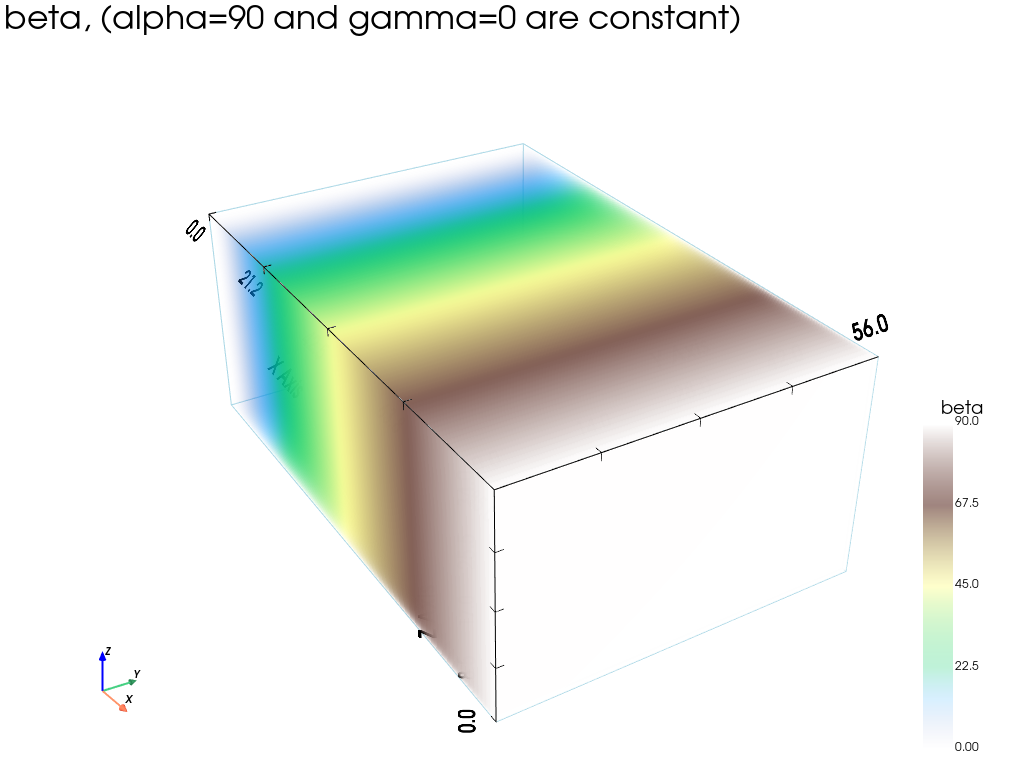

In [8]:
# Plot non-stationarities

# Set variable beta image im
im.append_var(beta, varname='beta')

# Plot "interactive in pop-up window" or "inline" (comment the undesired one) ...
# ... interactive (after closing the pop-up window, the position of the camera is retrieved in output)
#pp = pv.Plotter(notebook=False)
# ... inline
pp = pv.Plotter()

gn.imgplot3d.drawImage3D_volume(
    im, 
    plotter=pp,
    cmap='terrain',
    text=f'beta, (alpha={alpha} and gamma={gamma} are constant)',
    show_bounds=True,
    scalar_bar_kwargs={'vertical':True, 'label_font_size':12})

cpos = pp.show(cpos=(165, -100, 115), return_cpos=True) # position of the camera can be specified


## Set-up (for estimation and simulation)

In [9]:
# Data
x = np.array([[ 10.25,  20.14,  3.15], 
              [ 40.50,  10.50, 10.50], 
              [ 30.65,  40.53, 20.24],
              [ 30.18,  30.14, 30.98]]) # data locations (real coordinates)
v = [ -3.,  2.,   5.,  -1.]  # data values
v_err_std = 0.0                  # data error standard deviation
# v_err_std = [0.0, 0.0, 0.3, 1.0]   # data error standard deviation
                                   #   float: same for all data points
                                   #   list or array: per data point

# Inequality data
x_ineq = np.array([[ 10.25,  10.35,  6.51],
                   [ 50.15,  20.35, 20.50],
                   [ 65.50,   5.50,  3.50]]) # locations (real coordinates)
v_ineq_min = [    4., -2.3, np.nan]  # lower bounds
v_ineq_max = [np.nan, -1.7,   -4.1]  # upper bounds
# x_ineq = None
# v_ineq_min = None
# v_ineq_max = None

# Type of kriging
method = 'simple_kriging'

# Non-stationarities for covariance model: see angles `alpha`, `beta`, `gamma` for local rotation

### Estimation (kriging)

In [10]:
# Computational resources
nthreads = 8
nproc_sgs_at_ineq = None # default: nthreads (used for simulation at ineq. data points)

# Seed (used for simulation at ineq. data points)
seed = 913

t1 = time.time() # start time
geosclassic_output = gn.geosclassicinterface.estimate(
                            cov_model,                     # covariance model (required)
                            dimension, spacing, origin,    # grid geometry (dimension is required)
                            x=x, v=v, v_err_std=v_err_std, # data 
                            x_ineq=x_ineq,                 # inequality data ...
                            v_ineq_min=v_ineq_min, 
                            v_ineq_max=v_ineq_max, 
                            alpha=alpha,                   # rotation...
                            beta=beta,
                            gamma=gamma,
                            method=method,                 # type of kriging
                            use_unique_neighborhood=False, # search neighborhood (unique cannot be used with non-stationarities)...
                            searchRadius=None,             # ... used for simulation at ineq. data points
                            searchRadiusRelative=4.0, 
                            nneighborMax=12,
                            seed=seed,                     # seed (used for simulation at ineq. data points)
                            nthreads=nthreads,             # computational resources
                            nproc_sgs_at_ineq=nproc_sgs_at_ineq,
                            verbose=2                      # verbose mode
                        )
t2 = time.time() # end time
print('Elapsed time: {:.2g} sec'.format(t2-t1))

krig_img = geosclassic_output['image'] # output image

estimate: Preprocessing data done: final number of data points : 4, inequality data points: 3
estimate: Computational resources: nthreads = 8, nproc_sgs_at_ineq = 8
estimate: (Step 1.1) Do sgs at inequality data points (100 simulation(s) at 3 points)...
estimate: (Step 1.2) Transform inequality data to equality data with error std...
estimate: (Step 2) Set new dataset gathering data and inequality data locations...
estimate: (Step 3) Do kriging at the center of grid cells containing at least one data point...
estimate: (Step 4) Do kriging on the grid (at cell centers) using data points at cell centers...
estimate: Geos-Classic running on 1 process... [VERSION 2.1 / BUILD NUMBER 20251023 / OpenMP 8 thread(s)]
run_MPDSOMPGeosClassicSim: Geos-Classic running... [VERSION 2.1 / BUILD NUMBER 20251023 / OpenMP 8 thread(s)]
run_MPDSOMPGeosClassicSim: Geos-Classic run complete
estimate: Geos-Classic (1 process) run complete
estimate: warnings encountered (86354 times in all):
#  1: WARNING 0200

### Simulations

In [11]:
# Number of realizations
nreal = 50

# Seed
seed = 321

# Simulation mode (in case where there is inequality data)
mode_transform_ineq_to_data = False # Transform ineq. to data with err ?

# Computational resources
nproc = 2
nthreads_per_proc = 4
nproc_sgs_at_ineq = None # default: nthreads (used for simulation at ineq. data points)

t1 = time.time() # start time
geosclassic_output = gn.geosclassicinterface.simulate(
                            cov_model,                     # covariance model (required)
                            dimension, spacing, origin,    # grid geometry (dimension is required)
                            x=x, v=v, v_err_std=v_err_std, # data 
                            x_ineq=x_ineq,                 # inequality data ...
                            v_ineq_min=v_ineq_min, 
                            v_ineq_max=v_ineq_max, 
                            alpha=alpha,                   # rotation...
                            beta=beta,
                            gamma=gamma,
                            mode_transform_ineq_to_data=mode_transform_ineq_to_data,
                            method=method,                 # type of kriging
                            searchRadius=None,             # search neighborhood ...
                            searchRadiusRelative=1.2, 
                            nneighborMax=12,
                            nreal=nreal,                   # number of realizations
                            seed=seed,                     # seed
                            nproc=nproc,                   # computational resources ...
                            nthreads_per_proc=nthreads_per_proc, 
                            nproc_sgs_at_ineq=nproc_sgs_at_ineq,
                            verbose=2                      # verbose mode
                        )
t2 = time.time() # end time
print('Elapsed time: {:.2g} sec'.format(t2-t1))

simul_img = geosclassic_output['image'] # output image


simulate: Preprocessing data done: final number of data points : 4, inequality data points: 3
simulate: Computational resources: nproc = 2, nthreads_per_proc = 4, nproc_sgs_at_ineq = 8
simulate: (Step 1.1) Do sgs at inequality data points (50 simulation(s) at 3 points)...
simulate: (Step 2-4): Krige + Geos-Classic running on 2 process(es)... [VERSION 2.1 / BUILD NUMBER 20251023 / OpenMP 4 thread(s)]
_run_krige_and_MPDSOMPGeosClassicSim [pid=0]: realization     0 of 24...
_run_krige_and_MPDSOMPGeosClassicSim [pid=0]: realization     1 of 24...
_run_krige_and_MPDSOMPGeosClassicSim [pid=0]: realization     2 of 24...
_run_krige_and_MPDSOMPGeosClassicSim [pid=0]: realization     3 of 24...
_run_krige_and_MPDSOMPGeosClassicSim [pid=0]: realization     4 of 24...
_run_krige_and_MPDSOMPGeosClassicSim [pid=0]: realization     5 of 24...
_run_krige_and_MPDSOMPGeosClassicSim [pid=0]: realization     6 of 24...
_run_krige_and_MPDSOMPGeosClassicSim [pid=0]: realization     7 of 24...
_run_krige_an

### Plot the results

In [12]:
# Compute mean and standard deviation (pixel-wise)
simul_img_mean = gn.img.imageContStat(simul_img, op='mean')
simul_img_std  = gn.img.imageContStat(simul_img, op='std')


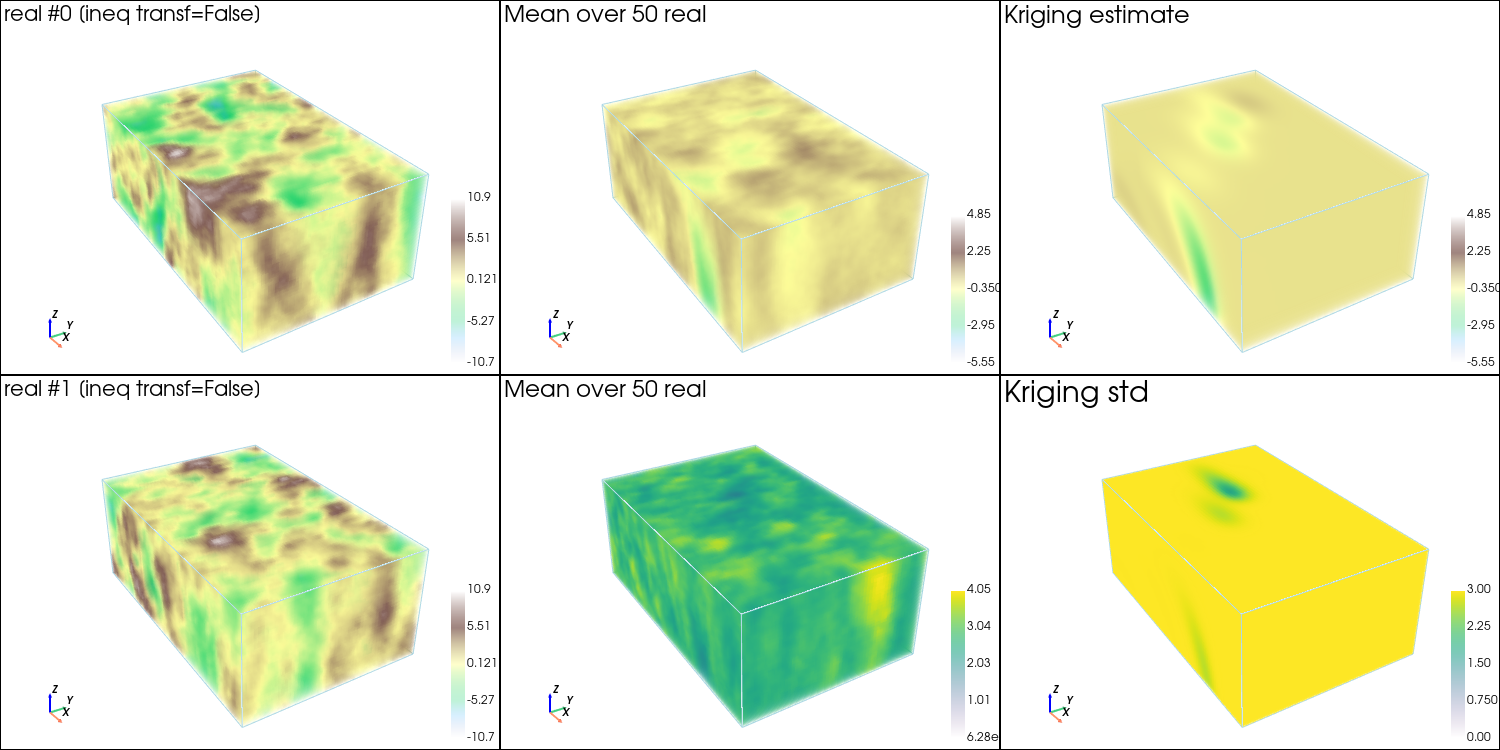

In [13]:
# Color settings
cmap = 'terrain'

cmin = np.min(simul_img.vmin()[0:1]) # min value for real 0 and 1
cmax = np.max(simul_img.vmax()[0:1]) # max value for real 0 and 1

cmin_2 = min(simul_img_mean.vmin()[0], krig_img.vmin()[0]) # min value for mean and kriging estimate
cmax_2 = max(simul_img_mean.vmax()[0], krig_img.vmax()[0]) # max value for mean and kriging estimate

cmap_std = 'viridis'

# Plot "interactive in pop-up window" or "inline" (comment the undesired one) ...
# ... interactive (after closing the pop-up window, the position of the camera is retrieved in output)
#pp = pv.Plotter(shape=(2, 3), window_size=(1500, 750), notebook=False)
# ... inline
pp = pv.Plotter(shape=(2, 3), window_size=(1500, 750))

# 2 first reals
for i in (0, 1):
    pp.subplot(i, 0)
    gn.imgplot3d.drawImage3D_volume(
        simul_img, iv=i, 
        plotter=pp,
        cmap=cmap, cmin=cmin, cmax=cmax,
        text=f'real #{i} [ineq transf={mode_transform_ineq_to_data}]',
        text_kwargs={'font_size':12},
        scalar_bar_kwargs={'title':i*' ', 'vertical':True, 'label_font_size':12})
        # note: scalar bar title : set new one for each plot to show the scalar bar...

# mean of all real
pp.subplot(0, 1)
gn.imgplot3d.drawImage3D_volume(
    simul_img_mean, 
    plotter=pp,
    cmap=cmap, cmin=cmin_2, cmax=cmax_2,
    text=f'Mean over {nreal} real',
    text_kwargs={'font_size':12},
    scalar_bar_kwargs={'title':2*' ', 'vertical':True, 'label_font_size':12})

# standard deviation of all real
pp.subplot(1, 1)
gn.imgplot3d.drawImage3D_volume(
    simul_img_std, 
    plotter=pp,
    cmap=cmap_std, 
    text=f'Mean over {nreal} real',
    text_kwargs={'font_size':12},
    scalar_bar_kwargs={'title':3*' ', 'vertical':True, 'label_font_size':12})

# kriging estimate
pp.subplot(0, 2)
gn.imgplot3d.drawImage3D_volume(
    krig_img, iv=0, 
    plotter=pp,
    cmap=cmap, cmin=cmin_2, cmax=cmax_2,
    text=f'Kriging estimate',
    text_kwargs={'font_size':12},
    scalar_bar_kwargs={'title':4*' ', 'vertical':True, 'label_font_size':12})

# kriging std
pp.subplot(1, 2)
gn.imgplot3d.drawImage3D_volume(
    krig_img, iv=1, 
    plotter=pp,
    cmap=cmap_std, 
    text=f'Kriging std',
    text_kwargs={'font_size':12},
    scalar_bar_kwargs={'title':5*' ', 'vertical':True, 'label_font_size':12})

pp.link_views()

cpos = pp.show(cpos=(165, -100, 115), return_cpos=True) # position of the camera can be specified

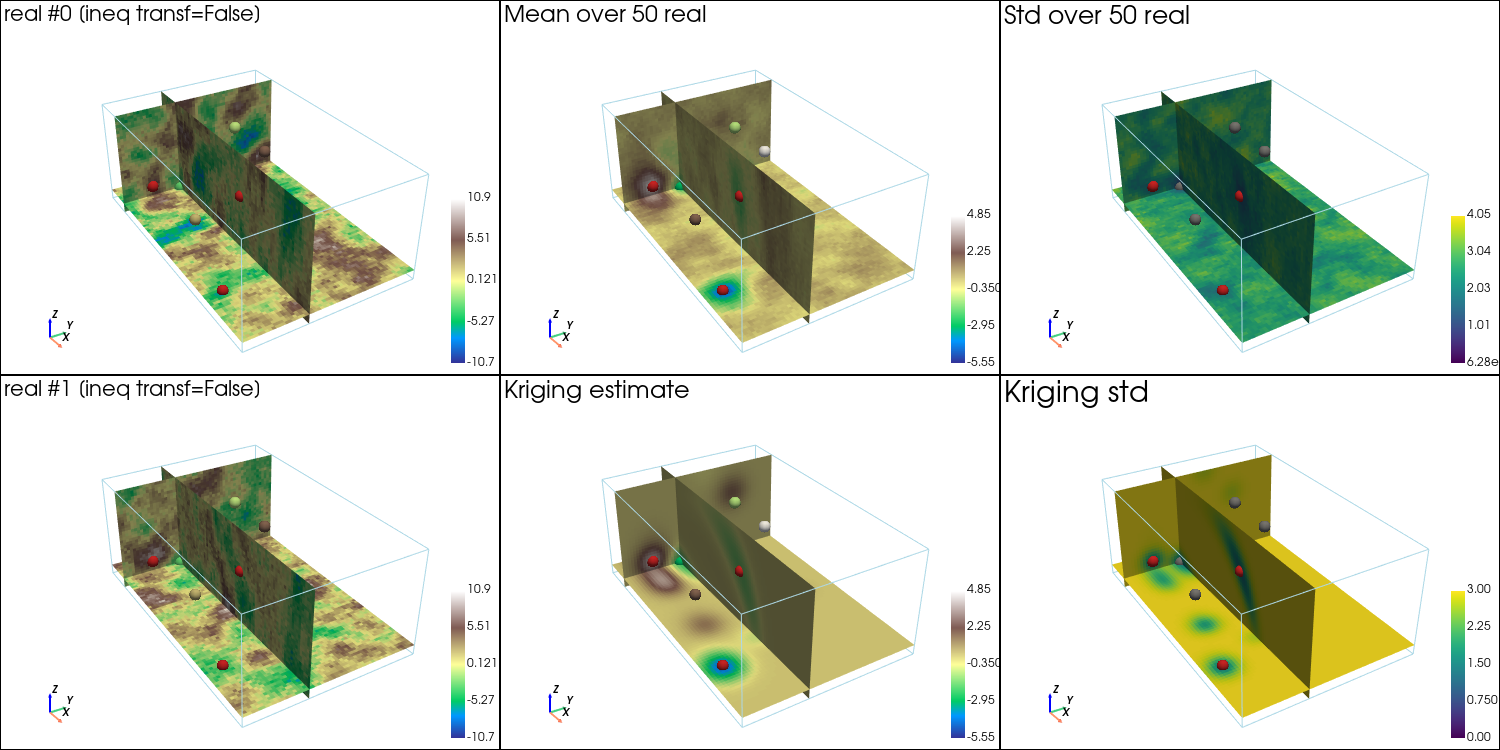

In [14]:
# Plot slices (with data points)
# ------------------------------
# Color settings
cmap = 'terrain'

# cmin = np.min(simul_img.vmin()[0:1]) # min value for real 0 and 1
# cmax = np.max(simul_img.vmax()[0:1]) # max value for real 0 and 1

# cmin_2 = min(simul_img_mean.vmin()[0], krig_img.vmin()[0]) # min value for mean and kriging estimate
# cmax_2 = max(simul_img_mean.vmax()[0], krig_img.vmax()[0]) # max value for mean and kriging estimate

cmap_std = 'viridis'

# Settings for plotting data
if x is not None:
    # Get colors for conditioning data according to their value and color settings
    data_points_col      = gn.imgplot.get_colors_from_values(v, cmap=cmap, cmin=cmin, cmax=cmax) 
    data_points_mean_col = gn.imgplot.get_colors_from_values(v, cmap=cmap, cmin=cmin_2, cmax=cmax_2) 

    # Set points to be plotted
    data_points = pv.PolyData(x)
    data_points['colors'] = data_points_col

    data_points_mean = pv.PolyData(x)
    data_points_mean['colors'] = data_points_mean_col

    # Set slices through data of index j
    j = 0
    slice_normal_x = x[j,0]
    slice_normal_y = x[j,1]
    slice_normal_z = x[j,2]
else:
    # Set default slices
    slice_normal_x = simul_img.x()[int(0.2*nx)]
    slice_normal_y = simul_img.y()[int(0.2*ny)]
    slice_normal_z = simul_img.z()[int(0.2*nz)]

if x_ineq is not None:
    # Set points to be plotted
    ineq_data_points = pv.PolyData(x_ineq)
    col_ineq = 'tab:red'

# Plot "interactive in pop-up window" or "inline" (comment the undesired one) ...
# ... interactive (after closing the pop-up window, the position of the camera is retrieved in output)
#pp = pv.Plotter(shape=(2,3), window_size=(1500, 750), notebook=False)
# ... inline
pp = pv.Plotter(shape=(2,3), window_size=(1500, 750))

# 2 first reals
for i in (0, 1):
    pp.subplot(i, 0)
    gn.imgplot3d.drawImage3D_slice(
        simul_img, iv=i, 
        plotter=pp,
        slice_normal_x=slice_normal_x,
        slice_normal_y=slice_normal_y,
        slice_normal_z=slice_normal_z,
        cmap=cmap, cmin=cmin, cmax=cmax,
        text=f'real #{i} [ineq transf={mode_transform_ineq_to_data}]',
        text_kwargs={'font_size':12},
        scalar_bar_kwargs={'title':i*' ', 'vertical':True, 'label_font_size':12})
        # note: scalar bar title : set new one for each plot to show the scalar bar...
    if x is not None:
        pp.add_mesh(data_points, rgb=True, point_size=12., render_points_as_spheres=True) # add data points
    if x_ineq is not None:
        pp.add_mesh(ineq_data_points, color=col_ineq, point_size=12., render_points_as_spheres=True) # add ineq. data points

# mean of all real
pp.subplot(0, 1)
gn.imgplot3d.drawImage3D_slice(
    simul_img_mean, 
    plotter=pp,
    slice_normal_x=slice_normal_x,
    slice_normal_y=slice_normal_y,
    slice_normal_z=slice_normal_z,
    cmap=cmap, cmin=cmin_2, cmax=cmax_2,
    text=f'Mean over {nreal} real',
    text_kwargs={'font_size':12},
    scalar_bar_kwargs={'title':2*' ', 'vertical':True, 'label_font_size':12})
if x is not None:
    pp.add_mesh(data_points_mean, rgb=True, point_size=12., render_points_as_spheres=True) # add data points
if x_ineq is not None:
    pp.add_mesh(ineq_data_points, color=col_ineq, point_size=12., render_points_as_spheres=True) # add ineq. data points

# standard deviation of all real
pp.subplot(0, 2)
gn.imgplot3d.drawImage3D_slice(
    simul_img_std, 
    plotter=pp,
    slice_normal_x=slice_normal_x,
    slice_normal_y=slice_normal_y,
    slice_normal_z=slice_normal_z,
    cmap=cmap_std, 
    text=f'Std over {nreal} real',
    text_kwargs={'font_size':12},
    scalar_bar_kwargs={'title':3*' ', 'vertical':True, 'label_font_size':12})
if x is not None:
    pp.add_mesh(data_points, color='gray', point_size=12., render_points_as_spheres=True) # add data points
if x_ineq is not None:
    pp.add_mesh(ineq_data_points, color=col_ineq, point_size=12., render_points_as_spheres=True) # add ineq. data points

# kriging estimate
pp.subplot(1, 1)
gn.imgplot3d.drawImage3D_slice(
    krig_img, iv=0, 
    plotter=pp,
    slice_normal_x=slice_normal_x,
    slice_normal_y=slice_normal_y,
    slice_normal_z=slice_normal_z,
    cmap=cmap, cmin=cmin_2, cmax=cmax_2,
    text=f'Kriging estimate',
    text_kwargs={'font_size':12},
    scalar_bar_kwargs={'title':4*' ', 'vertical':True, 'label_font_size':12})
if x is not None:
    pp.add_mesh(data_points_mean, rgb=True, point_size=12., render_points_as_spheres=True) # add data points
if x_ineq is not None:
    pp.add_mesh(ineq_data_points, color=col_ineq, point_size=12., render_points_as_spheres=True) # add ineq. data points

# kriging std
pp.subplot(1, 2)
gn.imgplot3d.drawImage3D_slice(
    krig_img, iv=1, 
    plotter=pp,
    slice_normal_x=slice_normal_x,
    slice_normal_y=slice_normal_y,
    slice_normal_z=slice_normal_z,
    cmap=cmap_std, 
    text=f'Kriging std',
    text_kwargs={'font_size':12},
    scalar_bar_kwargs={'title':5*' ', 'vertical':True, 'label_font_size':12})
if x is not None:
    pp.add_mesh(data_points, color='gray', point_size=12., render_points_as_spheres=True) # add data points
if x_ineq is not None:
    pp.add_mesh(ineq_data_points, color=col_ineq, point_size=12., render_points_as_spheres=True) # add ineq. data points

pp.link_views()

cpos = pp.show(cpos=(165, -100, 115), return_cpos=True) # position of the camera can be specified

### Check results
For each data point and inequality data point, the results obtained at the center of the grid cell containing the point are checked for
kriging (estimate or mean, with inequality data transform into data with error), and simulation (with or without ineq. data transform).

**Note:** Conditioning is "fully honoured" 
- for data points: located **exactly** in a cell center and with a **zero data error**
- for inequality data points: located **exactly** in a cell center and with `mode_transform_ineq_to_data=False`

In [15]:
# Check data
# ----------
if x is not None:
    # Get data error std (array)
    data_err_std = np.atleast_1d(v_err_std)
    if data_err_std.size==1:
        data_err_std = np.ones_like(v)*data_err_std[0]

    # Get index of conditioning location in the grid
    data_grid_index = [gn.img.pointToGridIndex(xk[0], xk[1], xk[2], sx, sy, sy, ox, oy, oy) for xk in x] # (ix, iy, iz) for each data point
    # Coordinate of cell center containing the data points
    x_center = np.asarray([[simul_img.xx()[iz, iy, ix], simul_img.yy()[iz, iy, ix], simul_img.zz()[iz, iy, ix]] for ix, iy, iz in data_grid_index])
    # Distance to center cell
    dist_to_x_center = np.sqrt(np.sum((np.asarray(x) - np.asarray(x_center))**2, axis=1))

    # Check
    for j in range(len(x)):
        print(f'Data point index {j}, dist. to cell center = {dist_to_x_center[j]:.4g}')
        ix, iy, iz = data_grid_index[j]                      # grid index of cell containing the data point
        krig_v_mu, krig_v_std = krig_img.val[:, iz, iy, ix]  # kriging estimate and std at cell center
        sim_v = simul_img.val[:, iz, iy, ix]                 # simulated values at cell center
        print(f'   data value                        = {v[j]:.3e} [data error std = {data_err_std[j]:.3e}]')
        print(f'   krig. mean value [transform=True] = {krig_v_mu:.3e} [krig. std = {krig_v_std:.3e}]')
        print(f'   simul. [transform={str(mode_transform_ineq_to_data):<5}]   : mean = {sim_v.mean() :.3e}, min = {sim_v.min() :.3e}, max = {sim_v.max() :.3e} [std = {sim_v.std() :.3e}]')


Data point index 0, dist. to cell center = 0.5609
   data value                        = -3.000e+00 [data error std = 0.000e+00]
   krig. mean value [transform=True] = -2.814e+00 [krig. std = 1.053e+00]
   simul. [transform=False]   : mean = -2.689e+00, min = -4.161e+00, max = -1.623e+00 [std = 6.039e-01]
Data point index 1, dist. to cell center = 0
   data value                        = 2.000e+00 [data error std = 0.000e+00]
   krig. mean value [transform=True] = 2.000e+00 [krig. std = 0.000e+00]
   simul. [transform=False]   : mean = 2.000e+00, min = 2.000e+00, max = 2.000e+00 [std = 6.280e-17]
Data point index 2, dist. to cell center = 0.3017
   data value                        = 5.000e+00 [data error std = 0.000e+00]
   krig. mean value [transform=True] = 4.726e+00 [krig. std = 9.921e-01]
   simul. [transform=False]   : mean = 4.360e+00, min = 3.173e+00, max = 5.488e+00 [std = 5.658e-01]
Data point index 3, dist. to cell center = 0.68
   data value                        = -1.000e

In [16]:
# Check inequality data
# ---------------------
if x_ineq is not None:
    # Get index of conditioning location in the grid
    ineq_data_grid_index = [gn.img.pointToGridIndex(xk[0], xk[1], xk[2], sx, sy, sy, ox, oy, oy) for xk in x_ineq] # (ix, iy, iz) for each data point
    # Coordinate of cell center containing the inequality data points
    x_ineq_center = np.asarray([[simul_img.xx()[iz, iy, ix], simul_img.yy()[iz, iy, ix], simul_img.zz()[iz, iy, ix]] for ix, iy, iz in ineq_data_grid_index])
    # Distance to center cell
    dist_to_x_ineq_center = np.sqrt(np.sum((np.asarray(x_ineq) - np.asarray(x_ineq_center))**2, axis=1))

    # Check
    for j in range(len(x_ineq)):
        print(f'Ineq. data point index {j}, dist. to cell center = {dist_to_x_ineq_center[j]:.4g}')
        ix, iy, iz = ineq_data_grid_index[j]     # grid index of cell containing the inequality data point
        krig_v_mu = krig_img.val[0, iz, iy, ix]  # kriging estimate at cell center
        sim_v = simul_img.val[:, iz, iy, ix]     # simulated values at cell center
        if not np.isnan(v_ineq_min[j]) and not np.isinf(v_ineq_min[j]):
            print(f'   does kriging mean value respect ineq data min [transform=True] : {krig_v_mu >= v_ineq_min[j]}')
            print(f'   percentage of simul. respecting ineq data min [transform={str(mode_transform_ineq_to_data):<5}]: {100*np.mean(sim_v >= v_ineq_min[j]):.3f}%')
        if not np.isnan(v_ineq_max[j]) and not np.isinf(v_ineq_max[j]):
            print(f'   does kriging mean value respect ineq data max [transform=True] : {krig_v_mu <= v_ineq_max[j]}')
            print(f'   percentage of simul. respecting ineq data max [transform={str(mode_transform_ineq_to_data):<5}]: {100*np.mean(sim_v <= v_ineq_max[j]):.3f}%')


Ineq. data point index 0, dist. to cell center = 0.2917
   does kriging mean value respect ineq data min [transform=True] : True
   percentage of simul. respecting ineq data min [transform=False]: 72.000%
Ineq. data point index 1, dist. to cell center = 0.3808
   does kriging mean value respect ineq data min [transform=True] : True
   percentage of simul. respecting ineq data min [transform=False]: 72.000%
   does kriging mean value respect ineq data max [transform=True] : True
   percentage of simul. respecting ineq data max [transform=False]: 54.000%
Ineq. data point index 2, dist. to cell center = 0
   does kriging mean value respect ineq data max [transform=True] : True
   percentage of simul. respecting ineq data max [transform=False]: 100.000%
